<a href="https://colab.research.google.com/github/ps-research/FinDex/blob/main/FinDex_PLOTS_MAKER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
EACL 2026 - Project 2: Financial Distress Analysis & Visualization
Generates all figures for main paper and appendices
"""

# ============================================================================
# IMPORTS
# ============================================================================

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import umap
from sklearn.preprocessing import MultiLabelBinarizer
from sentence_transformers import SentenceTransformer
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# High-quality plot settings
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

print("All imports successful!")

All imports successful!


In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# File paths - UPDATE THIS WITH YOUR PROJECT 2 PATH
DATASET_PATH = "/content/drive/MyDrive/🌟EACL 2026 🌟/EACL26-FinancialDiscussionsDataset.json"
OUTPUT_DIR = "/content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES"

# Create output directory
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Labels
INTENT_LABELS = [
    "Advocacy & Warning",
    "Community Building & Solidarity Seeking",
    "Emotional & Esteem Support-Seeking",
    "Informational Help-Seeking",
    "Instrumental Help-Seeking",
    "Sense-Making & Narrative Construction",
    "Venting / Catharsis"
]

IMPACT_LABELS = [
    "Behavioral Impact (Maladaptive Coping)",
    "Cognitive Impact",
    "Economic & Material Impact",
    "Physical Health Impact",
    "Psychological & Emotional Impact",
    "Relational & Social Impact"
]


INTENT_LABELS_SHORT = ["A&W", "CB&SS", "E&ESS", "IHS", "InHS", "SM&NC", "V/C"]
IMPACT_LABELS_SHORT = ["BI(MC)", "CI", "E&MI", "PHI", "P&EI", "R&SI"]

print(f"Configuration loaded")
print(f"Output directory: {OUTPUT_DIR}")

Configuration loaded
Output directory: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES


In [4]:
# ============================================================================
# LOAD DATA
# ============================================================================

with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Loaded {len(data)} samples")

# Extract components
texts = [sample['text'] for sample in data]
intent_labels = [sample['labels']['intent'] for sample in data]
impact_labels = [sample['labels']['impact'] for sample in data]

# Multi-label encoding
intent_mlb = MultiLabelBinarizer(classes=INTENT_LABELS)
impact_mlb = MultiLabelBinarizer(classes=IMPACT_LABELS)

intent_encoded = intent_mlb.fit_transform(intent_labels)
impact_encoded = impact_mlb.fit_transform(impact_labels)

print(f"Intent shape: {intent_encoded.shape}")
print(f"Impact shape: {impact_encoded.shape}")

Loaded 2408 samples
Intent shape: (2408, 7)
Impact shape: (2408, 6)


Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/fig1_correlation_matrix.pdf


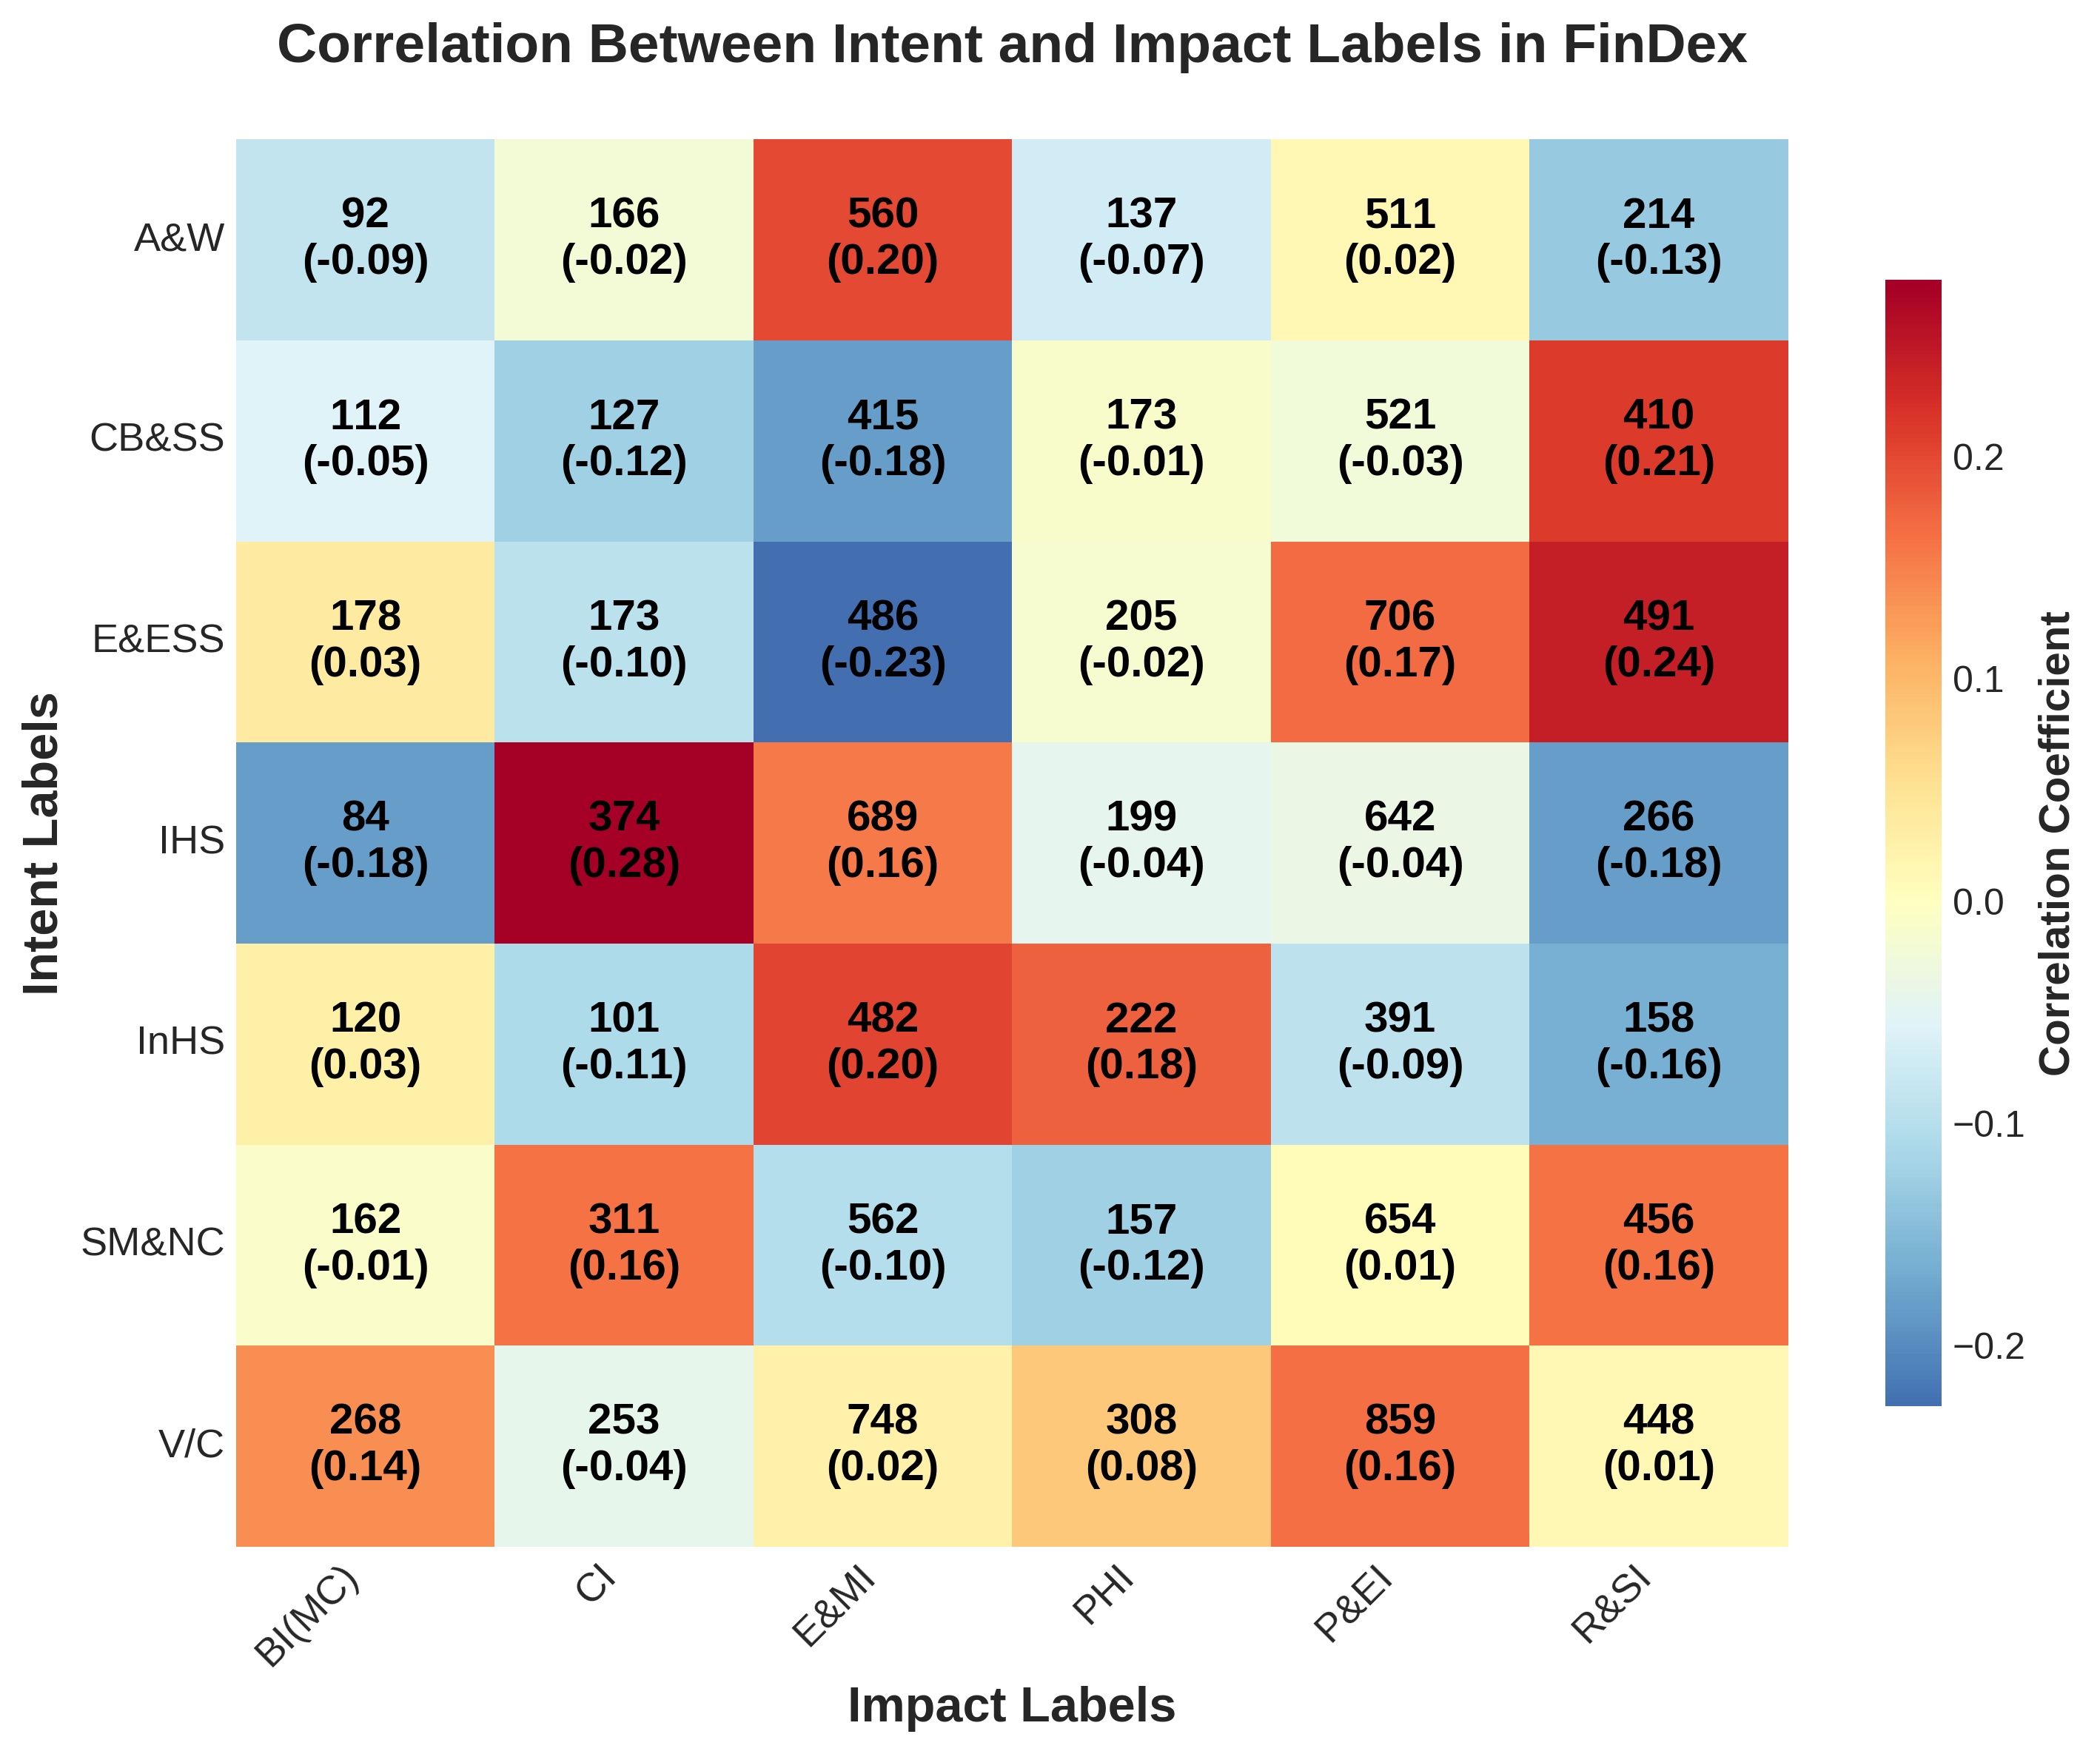

In [5]:
# ============================================================================
# MAIN PAPER FIGURE 1: INTENT-IMPACT CORRELATION MATRIX
# ============================================================================

def create_correlation_matrix(intent_encoded, impact_encoded, intent_labels, impact_labels,
                              color_scheme='Reds', title='Correlation Between Intent and Impact Labels'):
    """
    Create correlation matrix with count and correlation coefficient.
    FLIPPED: X-axis = Impact, Y-axis = Intent
    """
    fig, ax = plt.subplots(figsize=(10, 8))  # Swapped dimensions to match new orientation

    # Calculate correlation
    correlation_matrix = np.zeros((len(intent_labels), len(impact_labels)))
    count_matrix = np.zeros((len(intent_labels), len(impact_labels)))

    for i, intent_col in enumerate(intent_encoded.T):
        for j, impact_col in enumerate(impact_encoded.T):
            # Count co-occurrences
            count = np.sum(intent_col & impact_col)
            count_matrix[i, j] = count

            # Calculate Pearson correlation
            if np.std(intent_col) > 0 and np.std(impact_col) > 0:
                correlation = np.corrcoef(intent_col, impact_col)[0, 1]
            else:
                correlation = 0
            correlation_matrix[i, j] = correlation

    # NO TRANSPOSE - keep original orientation where rows=intent, cols=impact
    # This means: rows (Y-axis) = Intent, columns (X-axis) = Impact

    # Calculate dynamic color range
    vmin = correlation_matrix.min()
    vmax = correlation_matrix.max()

    # Create heatmap with FLIPPED axes
    sns.heatmap(correlation_matrix,
                annot=False,
                fmt='.2f',
                cmap='RdYlBu_r',  # Red-Yellow-Blue diverging
                xticklabels=impact_labels,  # Impact on X-axis (columns)
                yticklabels=intent_labels,  # Intent on Y-axis (rows)
                cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
                ax=ax,
                vmin=vmin, vmax=vmax,
                center=0)

    # Add custom annotations with LARGER font
    for i in range(len(intent_labels)):  # rows = intent
        for j in range(len(impact_labels)):  # cols = impact
            count = int(count_matrix[i, j])
            corr = correlation_matrix[i, j]

            # Format text
            text = f'{count}\n({corr:.2f})'

            # Add text with LARGER font
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center',
                   fontsize=14,  # Increased from 8
                   color='white' if corr > 0.5 else 'black',
                   fontweight='bold')

    # LARGER fonts for all text elements
    plt.title(title, fontsize=18, fontweight='bold', pad=25)
    plt.xlabel('Impact Labels', fontsize=16, fontweight='bold')  # Swapped
    plt.ylabel('Intent Labels', fontsize=16, fontweight='bold')  # Swapped

    # Increase tick label sizes
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Increase colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Correlation Coefficient', fontsize=14, fontweight='bold')

    plt.tight_layout()

    return fig

# Generate figure
fig = create_correlation_matrix(
    intent_encoded,
    impact_encoded,
    INTENT_LABELS_SHORT,
    IMPACT_LABELS_SHORT,
    color_scheme='Reds',
    title='Correlation Between Intent and Impact Labels in FinDex'
)

# Save
output_path = os.path.join(OUTPUT_DIR, 'fig1_correlation_matrix.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

# Display
plt.show()

In [6]:
# ============================================================================
# MAIN PAPER FIGURE 2: COMBINED UMAP SEMANTIC EMBEDDING (SIDE BY SIDE)
# ============================================================================


def create_combined_umap_embedding(texts, intent_encoded, impact_encoded,
                                   intent_labels, impact_labels,
                                   intent_labels_short, impact_labels_short):
    """
    Create side-by-side UMAP visualizations for intent and impact.
    """
    print(f"Generating embeddings...")

    # Load sentence transformer
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    embeddings = model.encode(texts, show_progress_bar=True)

    print(f"Reducing dimensions with UMAP...")

    # Apply UMAP
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_2d = reducer.fit_transform(embeddings)

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # ===== INTENT PLOT =====
    # Get dominant label for each sample
    dominant_labels_intent = []
    for sample_labels in intent_encoded:
        if sample_labels.sum() > 0:
            dominant_idx = np.argmax(sample_labels)
            dominant_labels_intent.append(intent_labels_short[dominant_idx])
        else:
            dominant_labels_intent.append('None')

    unique_labels_intent = list(set(dominant_labels_intent))
    if 'None' in unique_labels_intent:
        unique_labels_intent.remove('None')
    unique_labels_intent = sorted(unique_labels_intent)

    color_palette = plt.cm.get_cmap('tab10', len(unique_labels_intent))

    for idx, label in enumerate(unique_labels_intent):
        mask = np.array([l == label for l in dominant_labels_intent])
        ax1.scatter(embedding_2d[mask, 0],
                   embedding_2d[mask, 1],
                   label=label,
                   alpha=0.6,
                   s=40,
                   marker='o',
                   c=[color_palette(idx)])

    ax1.set_title('Semantic Clustering by Intent Labels', fontsize=16, fontweight='bold')
    ax1.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax1.set_ylabel('UMAP Dimension 2', fontsize=1)
    ax1.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax1.grid(True, alpha=0.3)

    # ===== IMPACT PLOT =====
    # Get dominant label for each sample
    dominant_labels_impact = []
    for sample_labels in impact_encoded:
        if sample_labels.sum() > 0:
            dominant_idx = np.argmax(sample_labels)
            dominant_labels_impact.append(impact_labels_short[dominant_idx])
        else:
            dominant_labels_impact.append('None')

    unique_labels_impact = list(set(dominant_labels_impact))
    if 'None' in unique_labels_impact:
        unique_labels_impact.remove('None')
    unique_labels_impact = sorted(unique_labels_impact)

    color_palette = plt.cm.get_cmap('Dark2', len(unique_labels_impact))

    for idx, label in enumerate(unique_labels_impact):
        mask = np.array([l == label for l in dominant_labels_impact])
        ax2.scatter(embedding_2d[mask, 0],
                   embedding_2d[mask, 1],
                   label=label,
                   alpha=0.6,
                   s=40,
                   marker='o',
                   c=[color_palette(idx)])

    ax2.set_title('Semantic Clustering by Impact Labels', fontsize=16, fontweight='bold')
    ax2.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax2.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax2.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig

Generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Reducing dimensions with UMAP...
Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/fig2_umap_combined.pdf


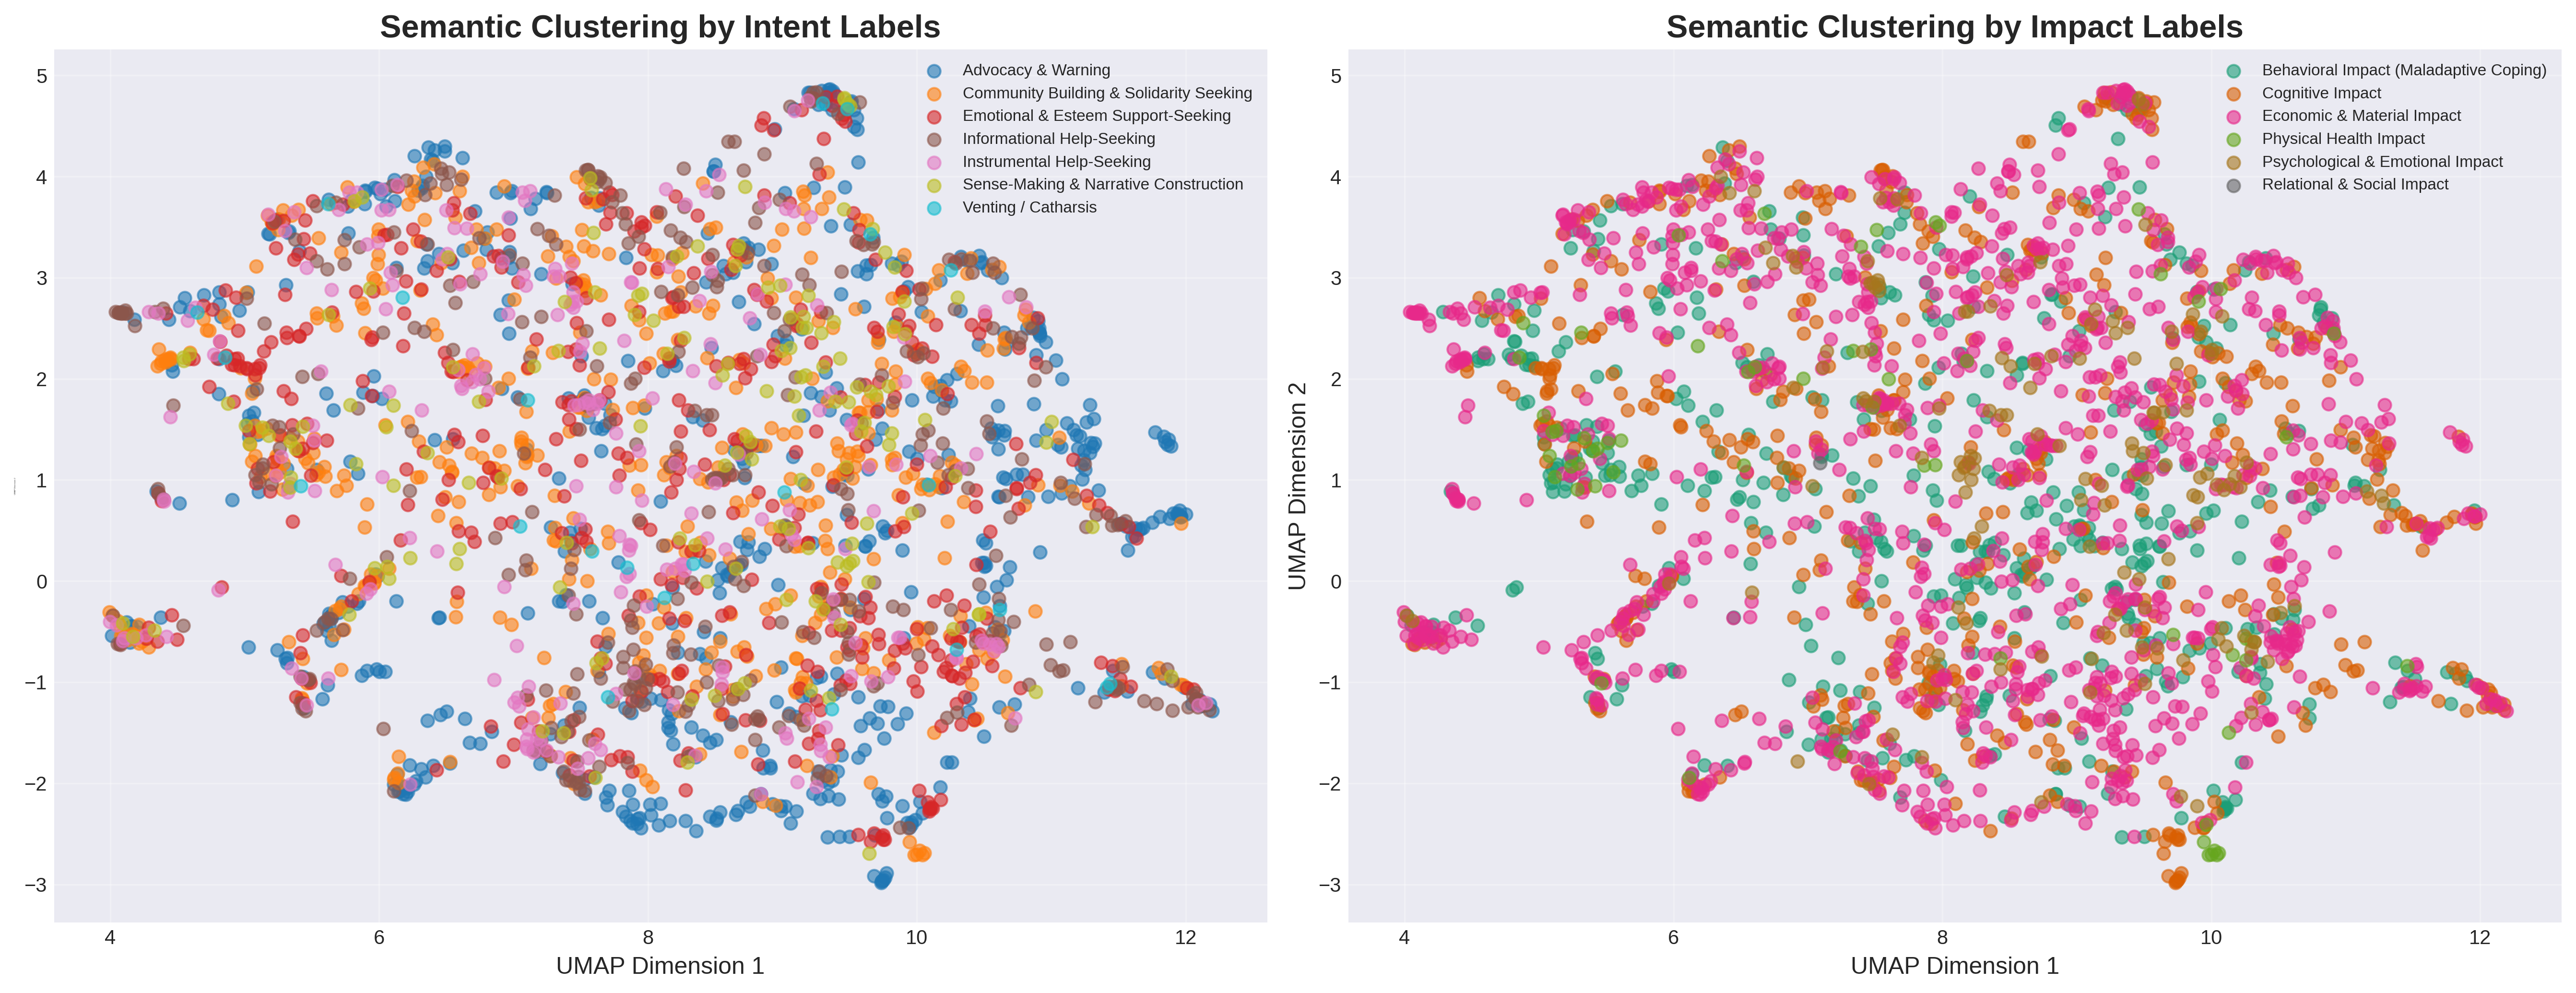

In [7]:
# Generate combined UMAP figure
fig = create_combined_umap_embedding(
    texts,
    intent_encoded,
    impact_encoded,
    INTENT_LABELS,
    IMPACT_LABELS,
    INTENT_LABELS,
    IMPACT_LABELS
)

# Save
output_path = os.path.join(OUTPUT_DIR, 'fig2_umap_combined.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/appendix_a1_label_distribution.pdf


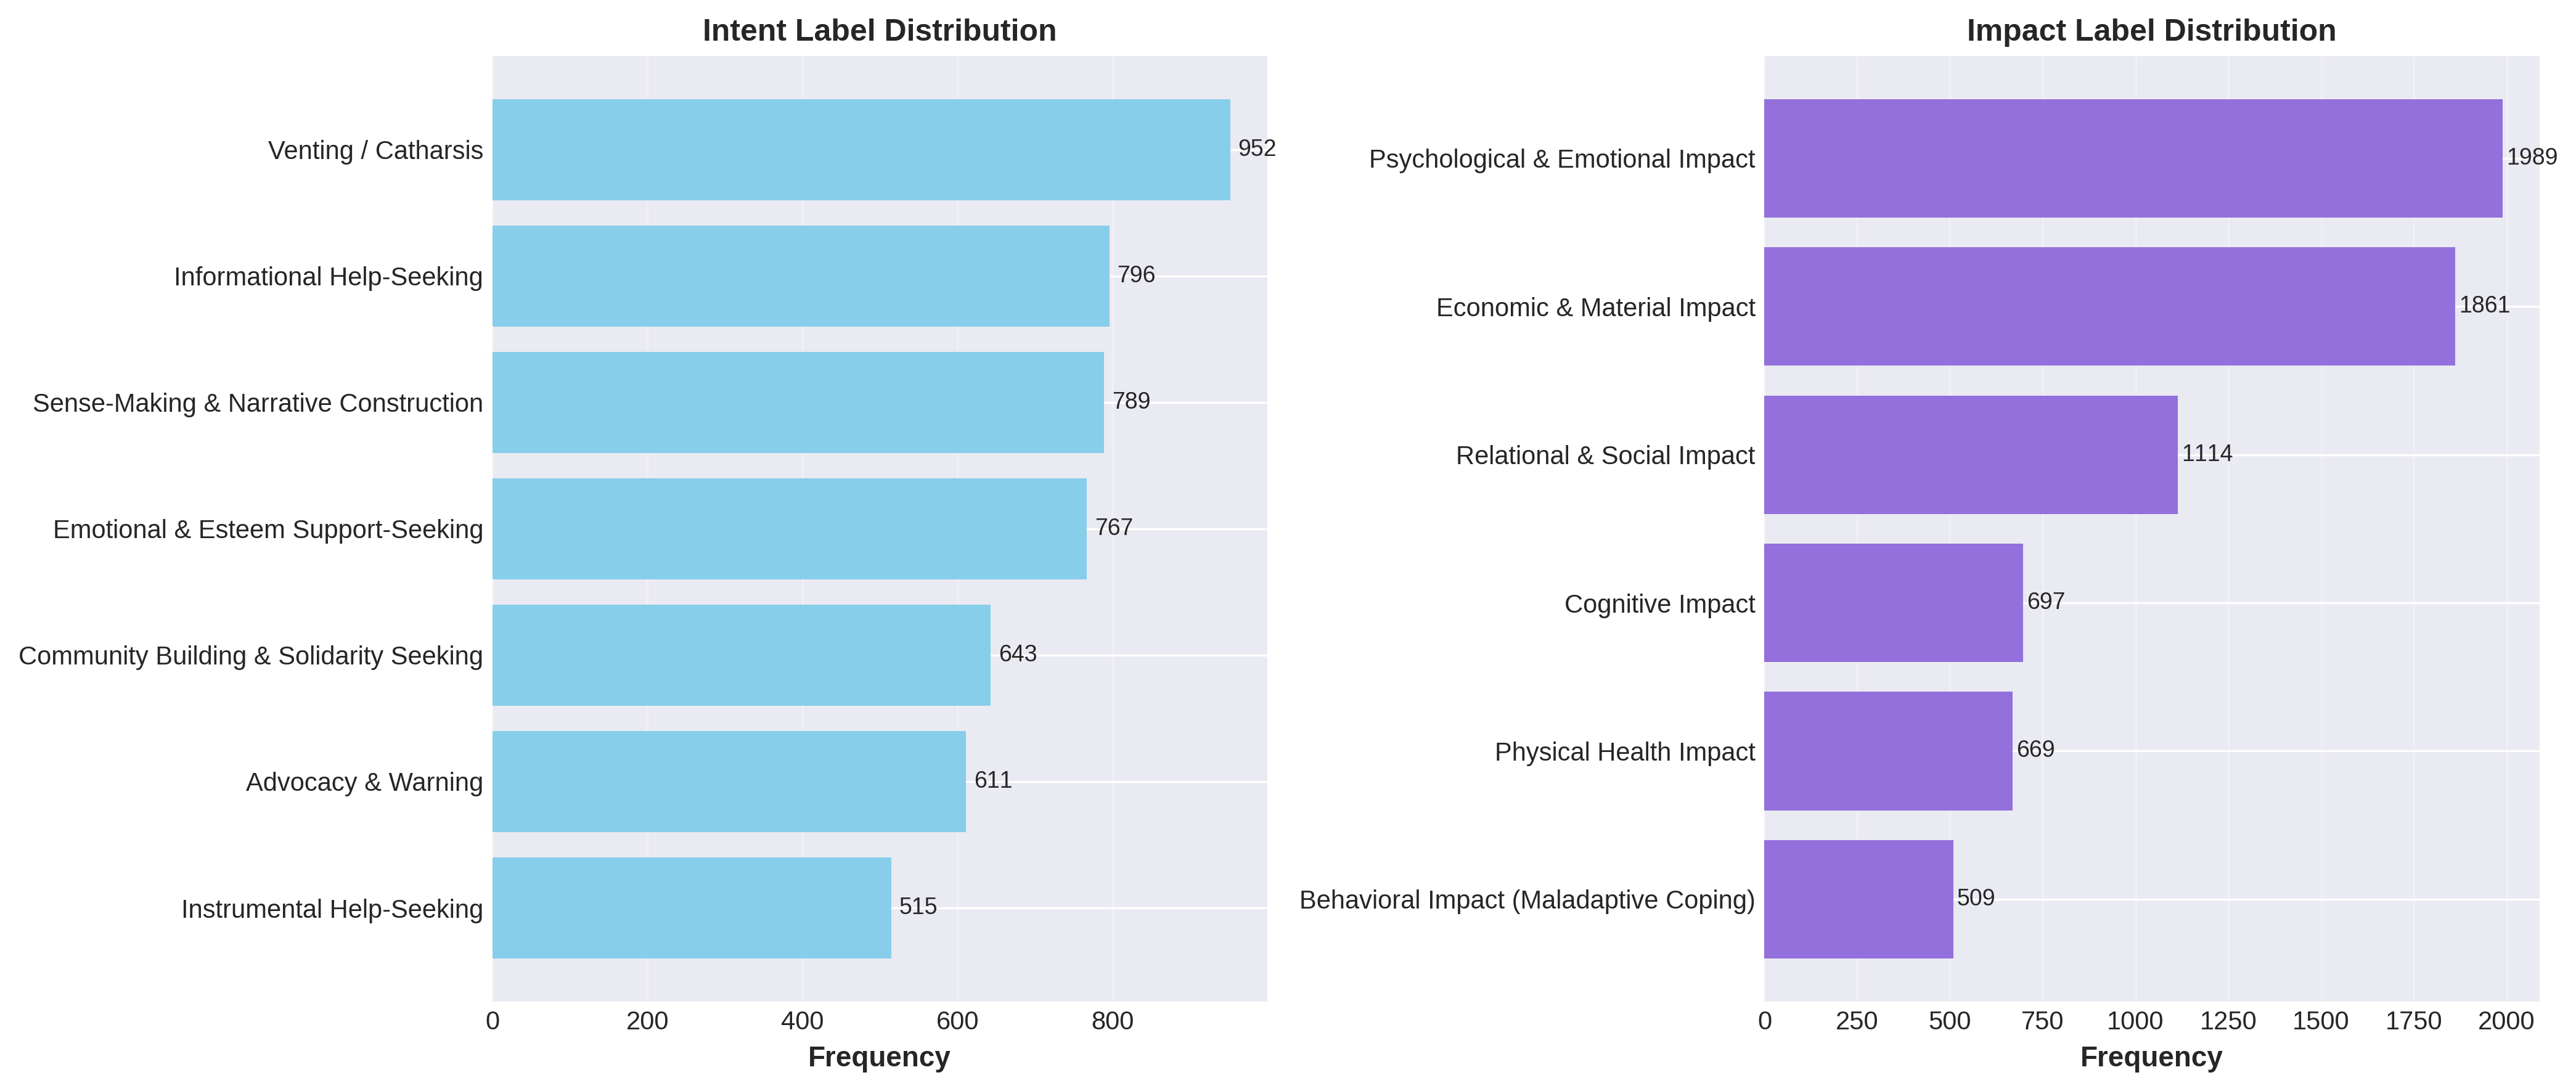

In [8]:
# ============================================================================
# APPENDIX A1: LABEL DISTRIBUTION
# ============================================================================

def create_label_distribution(intent_encoded, impact_encoded, intent_labels, impact_labels):
    """
    Create horizontal bar charts showing label frequencies.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Intent frequencies
    intent_counts = intent_encoded.sum(axis=0)
    intent_df = pd.DataFrame({
        'Label': intent_labels,
        'Count': intent_counts
    }).sort_values('Count', ascending=True)

    ax1.barh(intent_df['Label'], intent_df['Count'], color='skyblue')
    ax1.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Intent Label Distribution', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Add count labels
    for i, (label, count) in enumerate(zip(intent_df['Label'], intent_df['Count'])):
        ax1.text(count + 10, i, str(int(count)), va='center', fontsize=9)

    # Impact frequencies
    impact_counts = impact_encoded.sum(axis=0)
    impact_df = pd.DataFrame({
        'Label': impact_labels,
        'Count': impact_counts
    }).sort_values('Count', ascending=True)

    ax2.barh(impact_df['Label'], impact_df['Count'], color='mediumpurple')
    ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('Impact Label Distribution', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # Add count labels
    for i, (label, count) in enumerate(zip(impact_df['Label'], impact_df['Count'])):
        ax2.text(count + 10, i, str(int(count)), va='center', fontsize=9)

    plt.tight_layout()

    return fig

# Generate figure
fig = create_label_distribution(intent_encoded, impact_encoded, INTENT_LABELS, IMPACT_LABELS)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a1_label_distribution.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/appendix_a2_post_length_by_severity.pdf


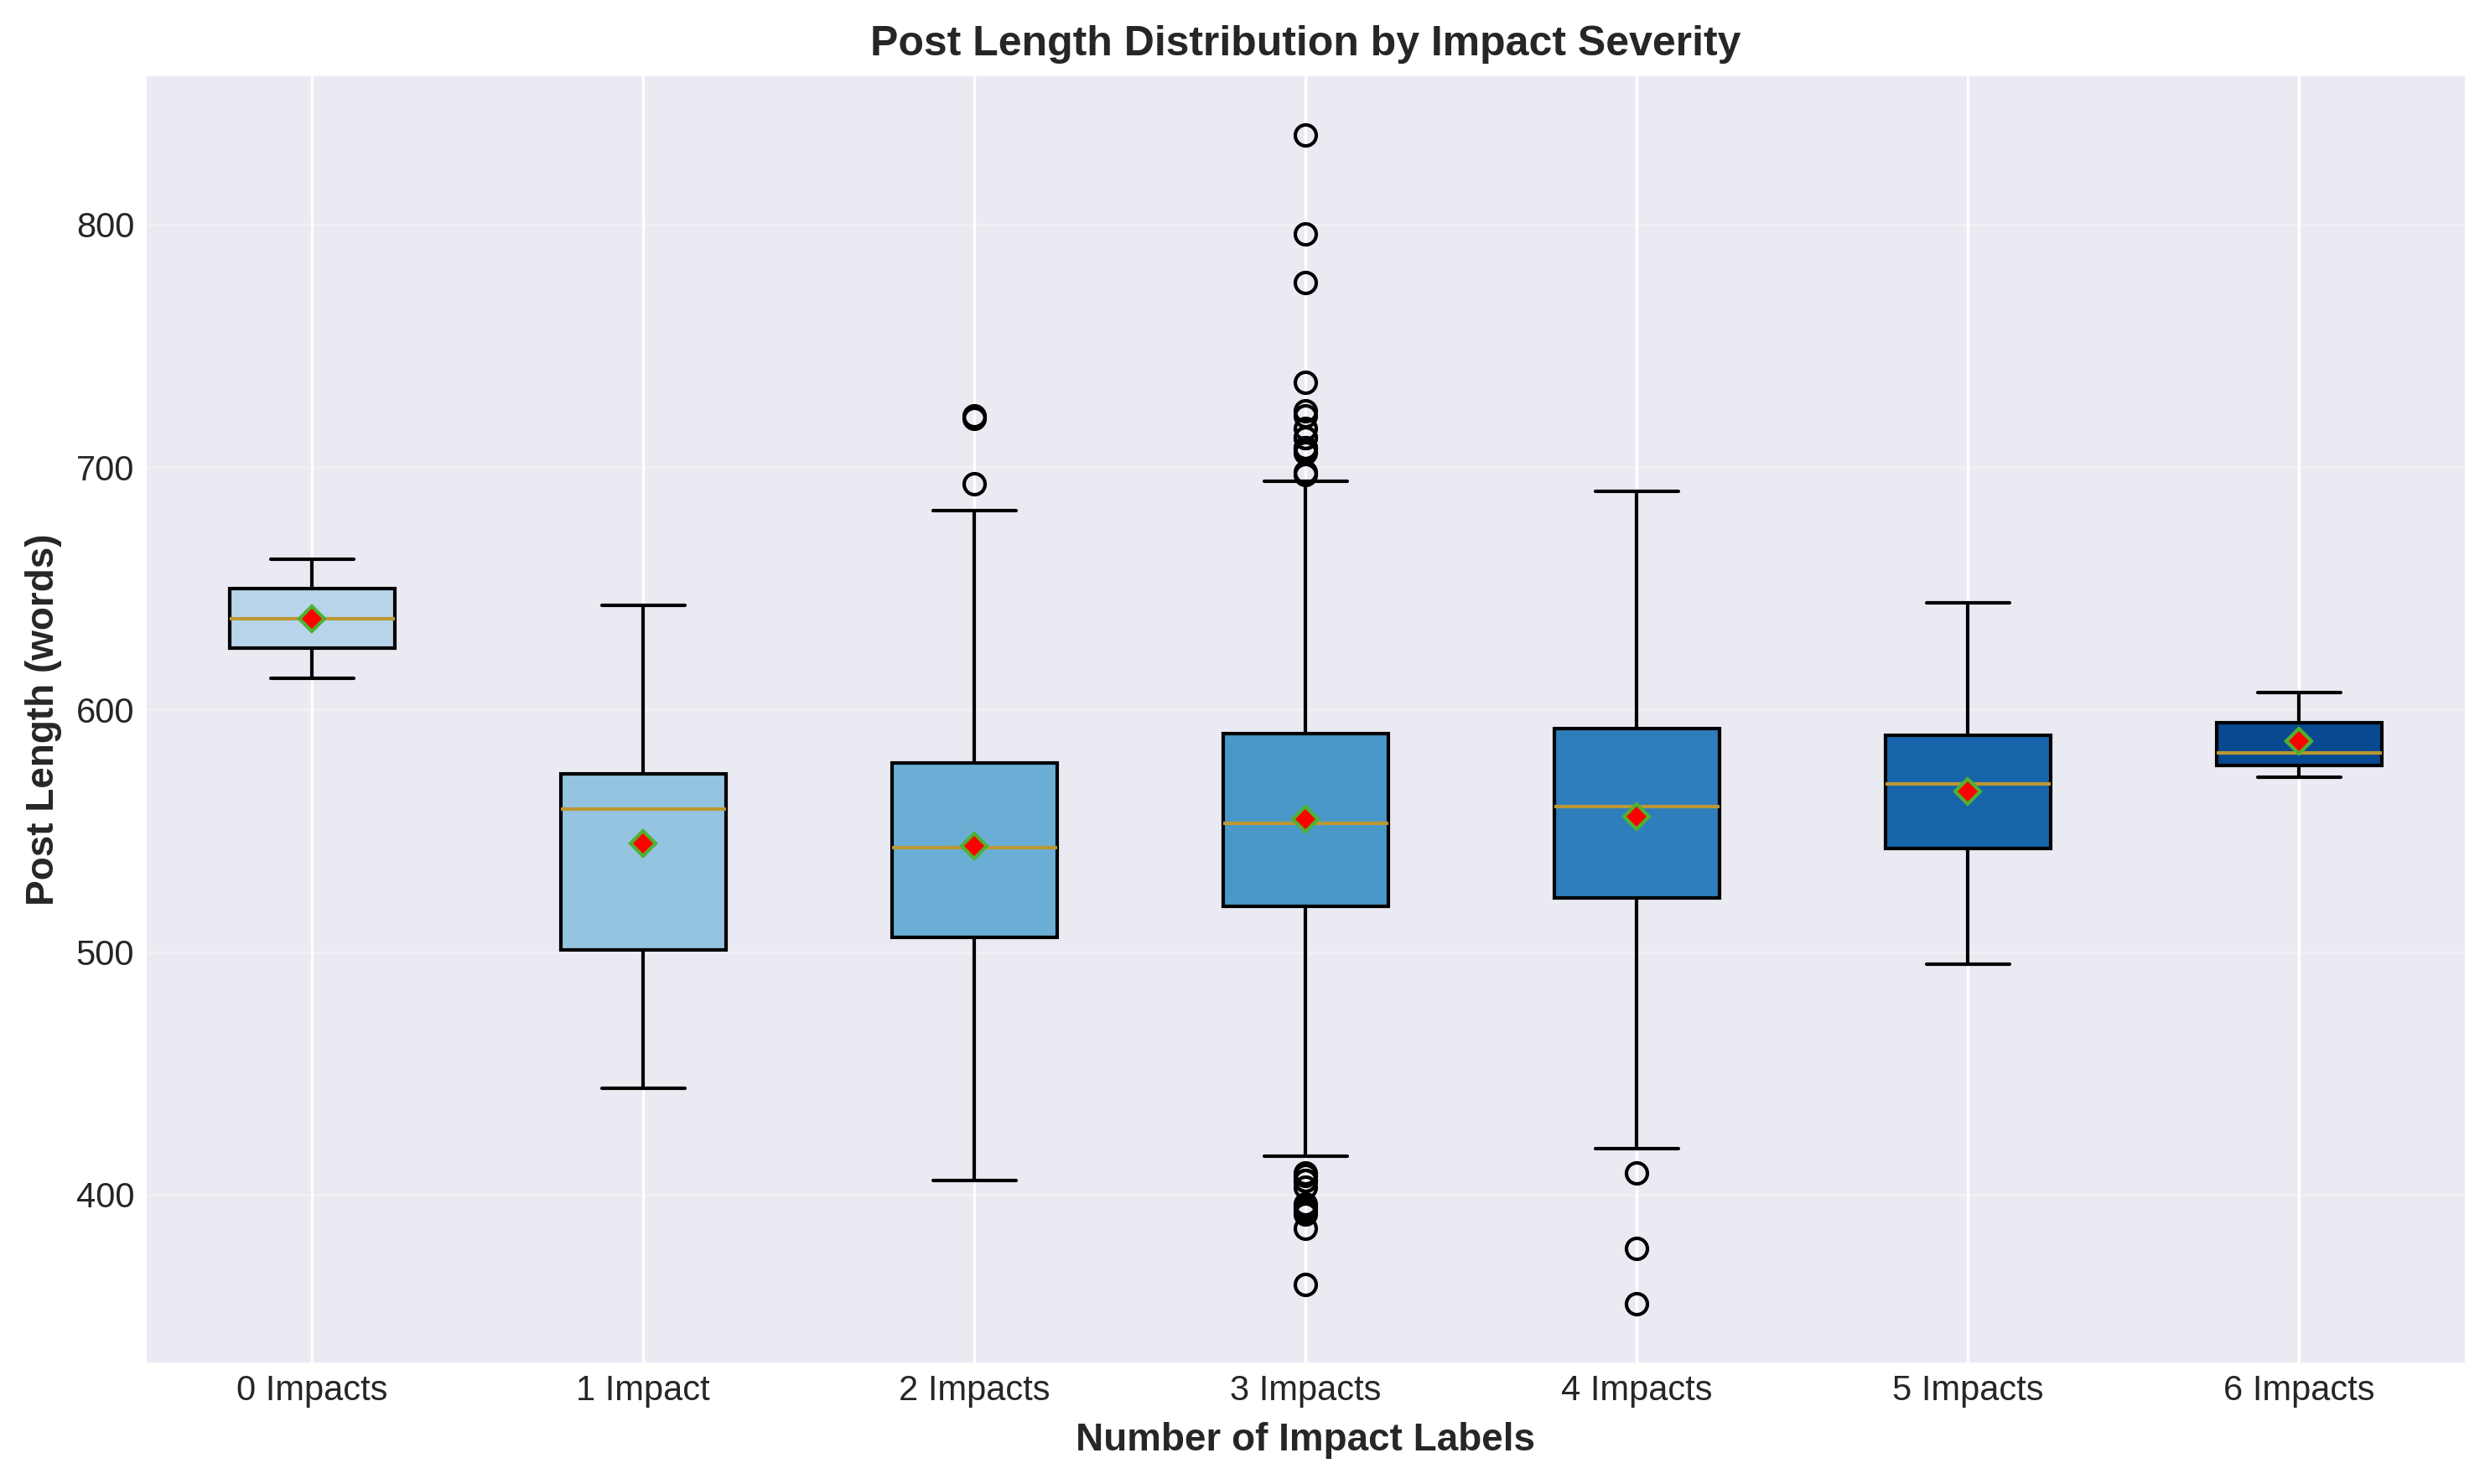

In [9]:
# ============================================================================
# APPENDIX A2: POST LENGTH BY IMPACT SEVERITY
# ============================================================================

def create_post_length_by_severity(texts, impact_encoded):
    """
    Create box plot showing post length by number of impacts.
    """
    # Calculate post lengths
    post_lengths = [len(text.split()) for text in texts]

    # Calculate number of impacts per post
    n_impacts = impact_encoded.sum(axis=1)

    # Organize data
    length_by_severity = {}
    for length, n_impact in zip(post_lengths, n_impacts):
        if n_impact not in length_by_severity:
            length_by_severity[n_impact] = []
        length_by_severity[n_impact].append(length)

    # Sort by severity
    severities = sorted(length_by_severity.keys())
    data_to_plot = [length_by_severity[s] for s in severities]
    labels = [f'{int(s)} Impact{"s" if s != 1 else ""}' for s in severities]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    bp = ax.boxplot(data_to_plot,
                    labels=labels,
                    patch_artist=True,
                    showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=5))

    # Color boxes with gradient
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(severities)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel('Post Length (words)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Number of Impact Labels', fontsize=11, fontweight='bold')
    ax.set_title('Post Length Distribution by Impact Severity', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    return fig

# Generate figure
fig = create_post_length_by_severity(texts, impact_encoded)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a2_post_length_by_severity.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/appendix_a3_financial_vocabulary.pdf


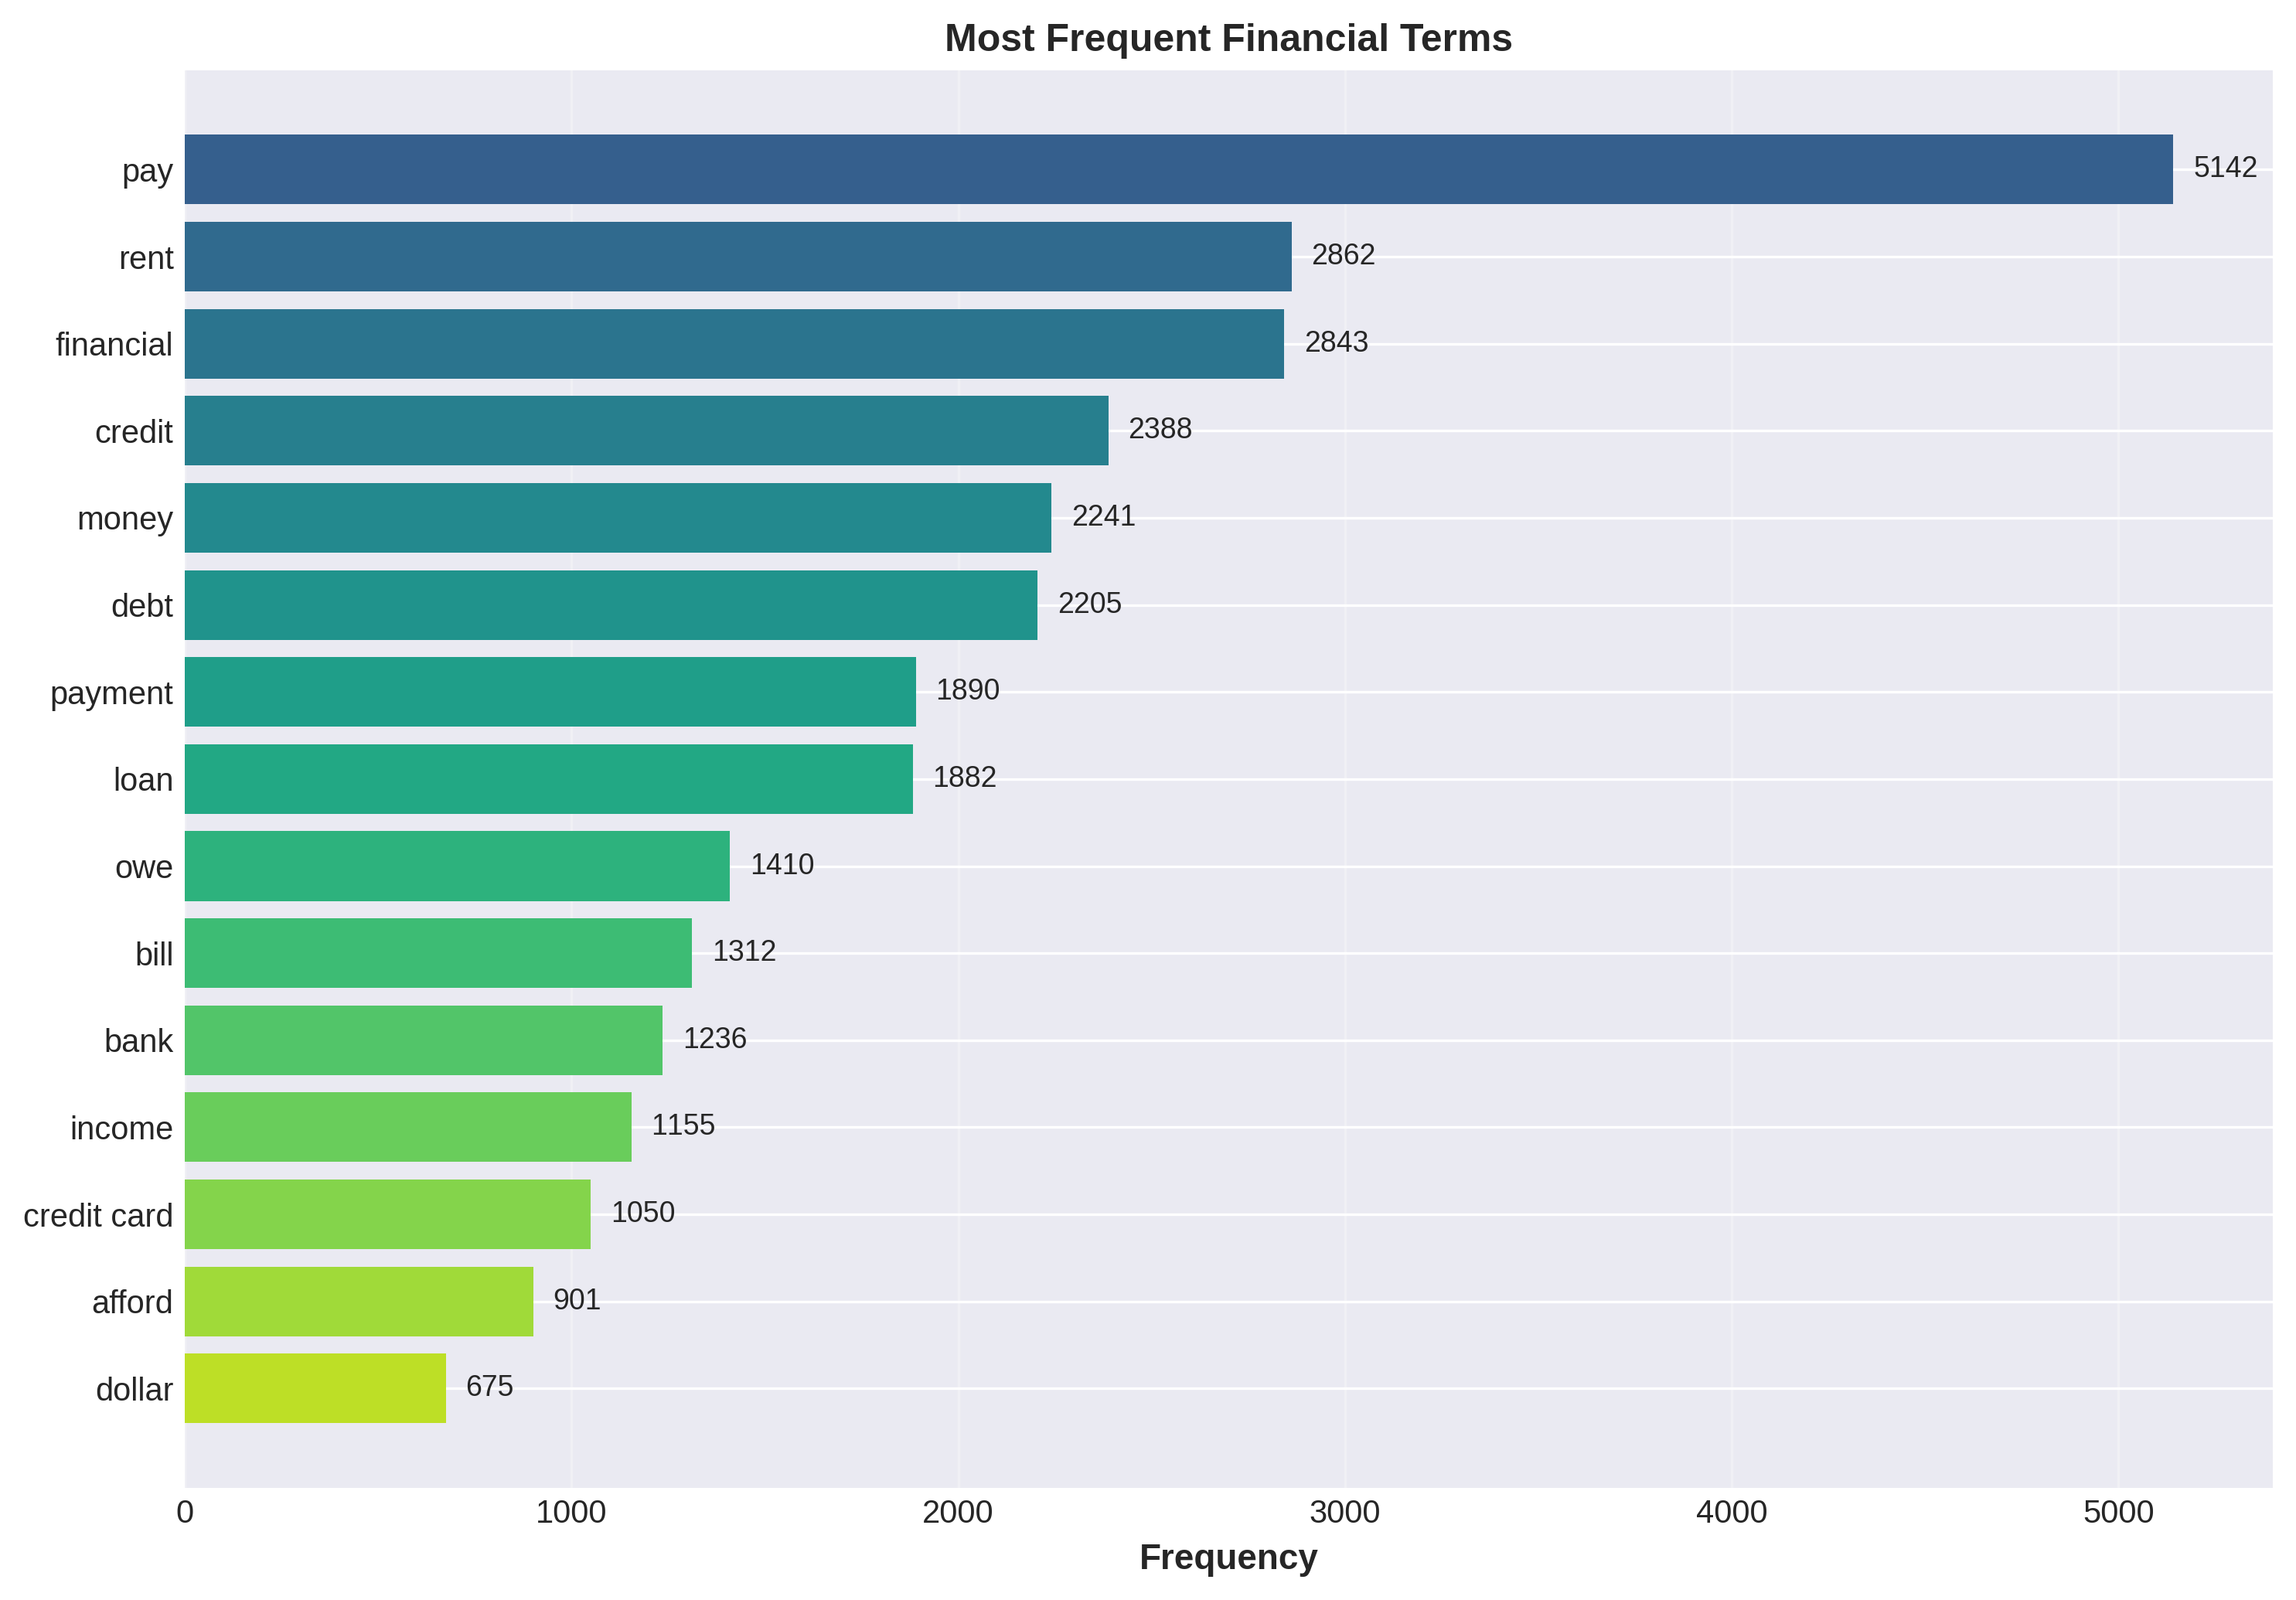

In [10]:
# ============================================================================
# APPENDIX A3: FINANCIAL VOCABULARY FREQUENCY
# ============================================================================

def create_financial_vocabulary_analysis(texts):
    """
    Create bar chart of most common financial terms.
    """
    # Financial keywords to search for
    financial_terms = [
        'debt', 'loan', 'student loan', 'credit', 'credit card',
        'rent', 'mortgage', 'bill', 'income', 'salary', 'pay',
        'afford', 'money', 'dollar', 'bank', 'interest',
        'payment', 'owe', 'financial', 'budget', 'expense'
    ]

    # Count occurrences
    term_counts = Counter()

    for text in texts:
        text_lower = text.lower()
        for term in financial_terms:
            # Count occurrences of each term
            count = text_lower.count(term)
            if count > 0:
                term_counts[term] += count

    # Get top 15 terms
    top_terms = term_counts.most_common(15)
    terms, counts = zip(*top_terms)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7))

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(terms)))
    bars = ax.barh(range(len(terms)), counts, color=colors)
    ax.set_yticks(range(len(terms)))
    ax.set_yticklabels(terms, fontsize=10)
    ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title('Most Frequent Financial Terms', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

    # Add count labels
    for i, (term, count) in enumerate(zip(terms, counts)):
        ax.text(count + max(counts)*0.01, i, str(count), va='center', fontsize=9)

    plt.tight_layout()

    return fig

# Generate figure
fig = create_financial_vocabulary_analysis(texts)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a3_financial_vocabulary.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/appendix_a4_dollar_amounts.pdf


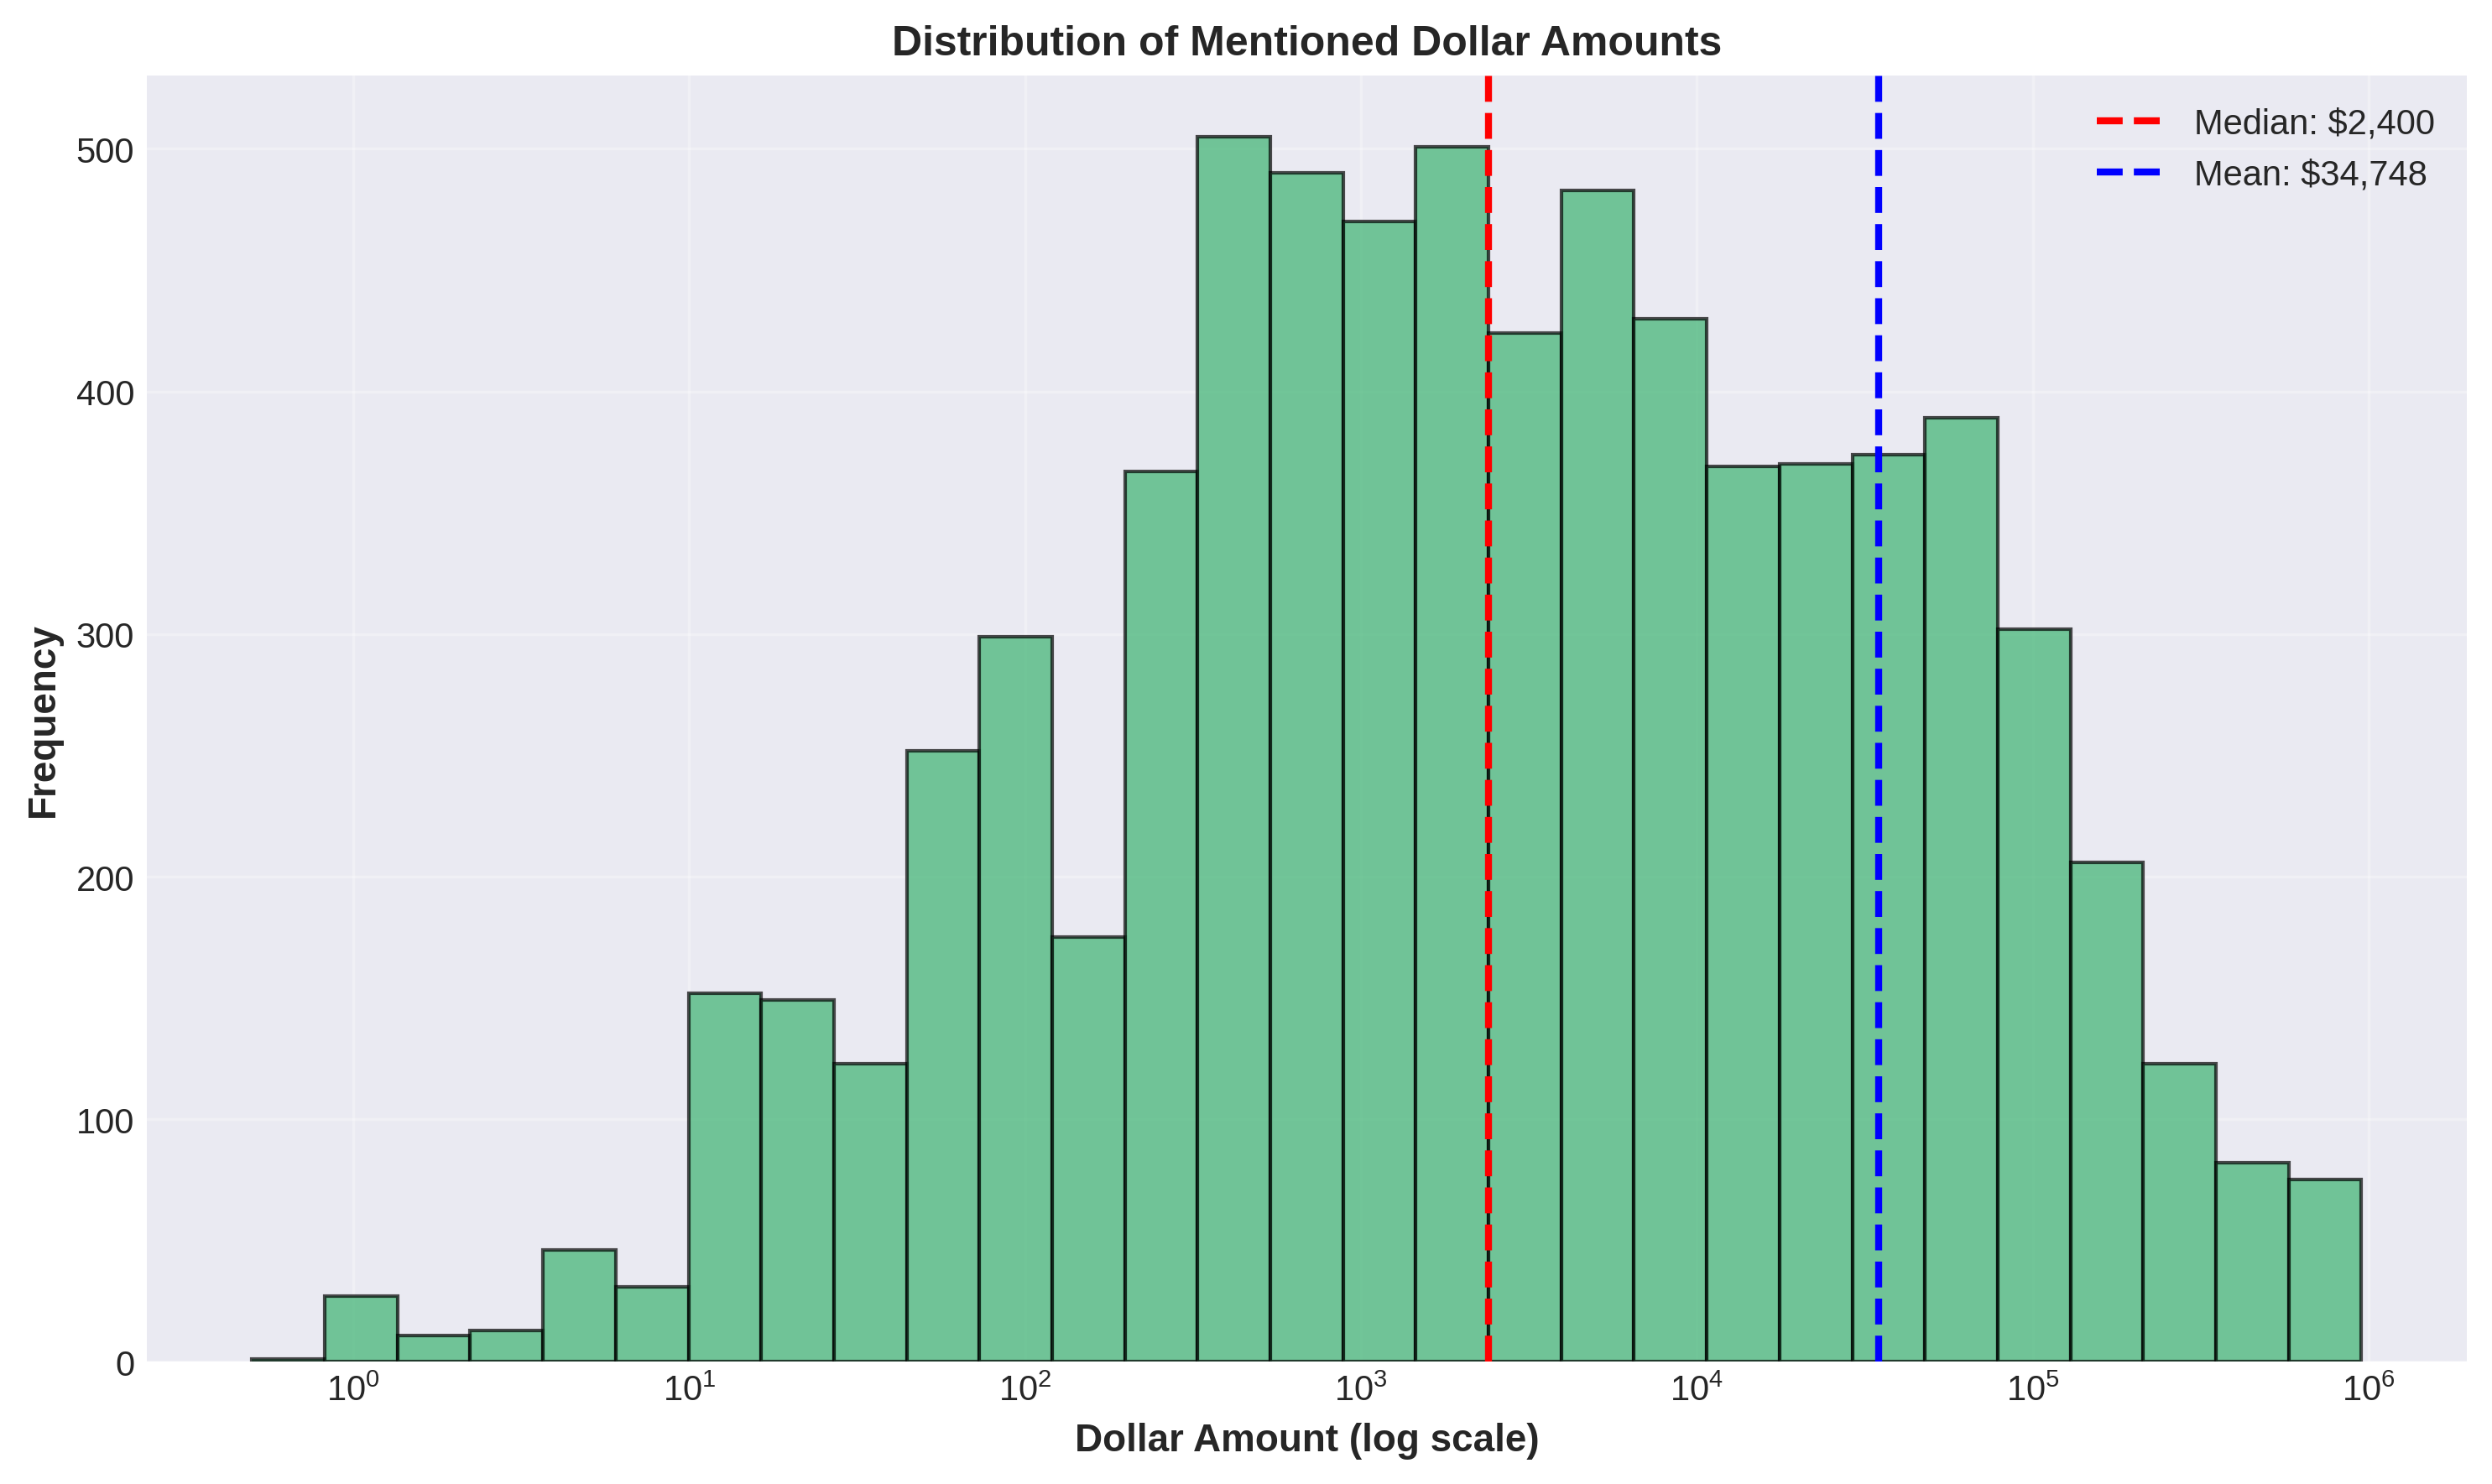

In [11]:
# ============================================================================
# APPENDIX A4: DOLLAR AMOUNT DISTRIBUTION
# ============================================================================

def create_dollar_amount_distribution(texts):
    """
    Create histogram of mentioned dollar amounts.
    """
    # Extract dollar amounts using regex
    dollar_pattern = r'\$[\d,]+(?:\.\d{2})?'

    amounts = []
    for text in texts:
        matches = re.findall(dollar_pattern, text)
        for match in matches:
            # Clean and convert to float
            amount_str = match.replace('$', '').replace(',', '')
            try:
                amount = float(amount_str)
                if amount > 0 and amount < 1000000:  # Filter outliers
                    amounts.append(amount)
            except:
                continue

    if len(amounts) == 0:
        print("No dollar amounts found in texts")
        return None

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Use log scale bins
    bins = np.logspace(np.log10(min(amounts)), np.log10(max(amounts)), 30)

    ax.hist(amounts, bins=bins, color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax.set_xscale('log')
    ax.set_xlabel('Dollar Amount (log scale)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title('Distribution of Mentioned Dollar Amounts', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add statistics
    median_amount = np.median(amounts)
    mean_amount = np.mean(amounts)
    ax.axvline(median_amount, color='red', linestyle='--', linewidth=2,
               label=f'Median: ${median_amount:,.0f}')
    ax.axvline(mean_amount, color='blue', linestyle='--', linewidth=2,
               label=f'Mean: ${mean_amount:,.0f}')
    ax.legend(fontsize=10)

    plt.tight_layout()

    return fig

# Generate figure
fig = create_dollar_amount_distribution(texts)

if fig is not None:
    # Save
    output_path = os.path.join(OUTPUT_DIR, 'appendix_a4_dollar_amounts.pdf')
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    print(f"Saved: {output_path}")
    plt.show()
else:
    print("Skipping dollar amount plot - no amounts found")

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/appendix_a5_emotional_vs_practical.pdf


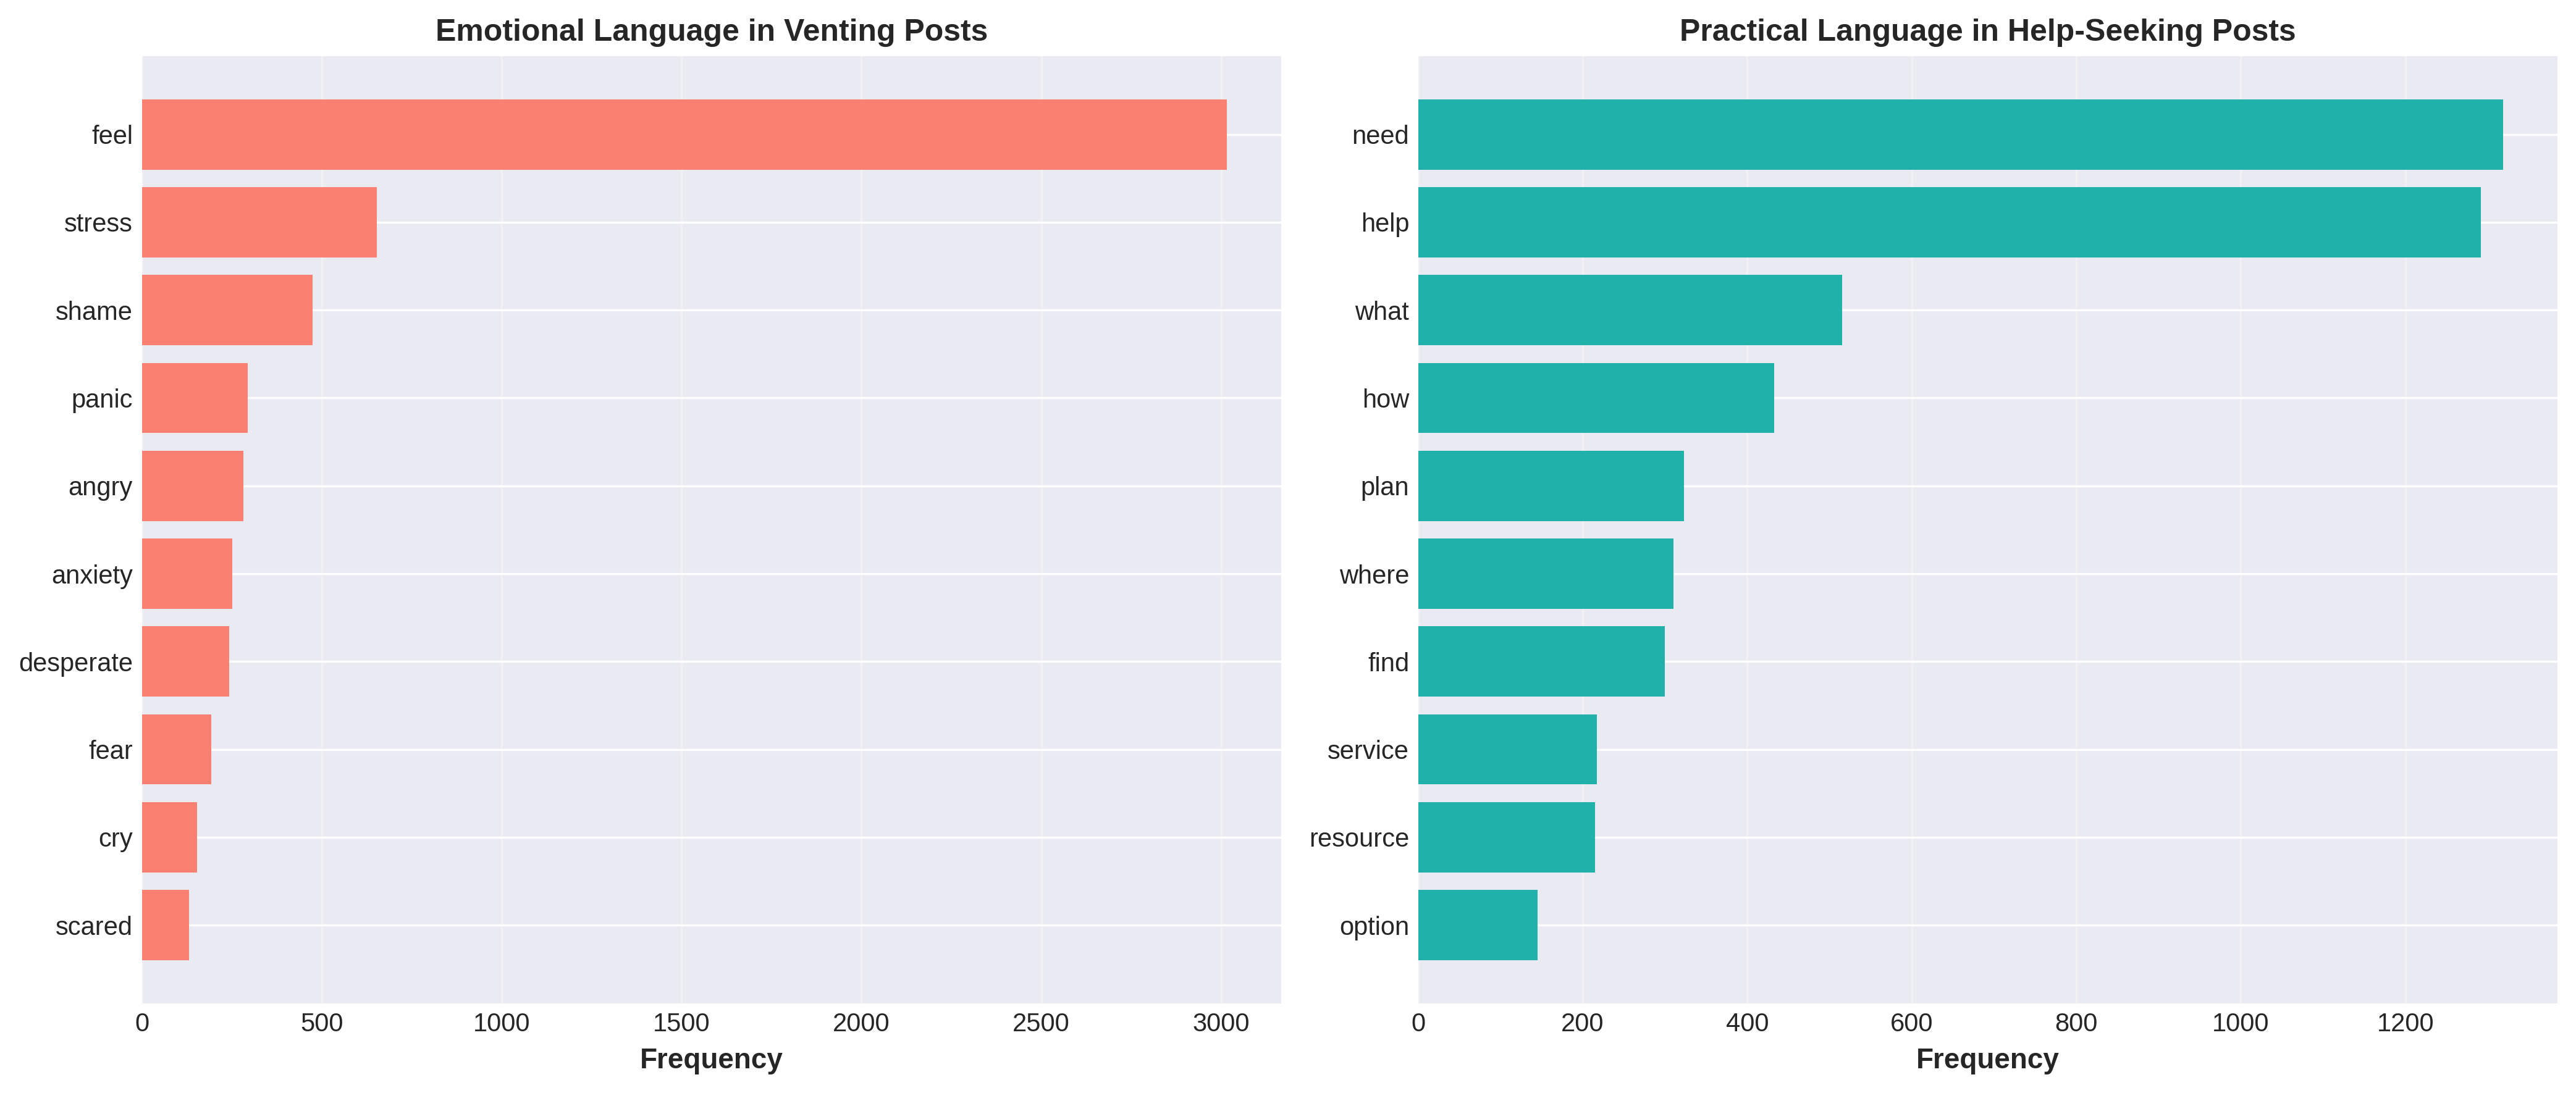

In [12]:
# ============================================================================
# APPENDIX A5: EMOTIONAL VS PRACTICAL LANGUAGE
# ============================================================================

def create_emotional_vs_practical_analysis(texts, intent_encoded, intent_labels):
    """
    Compare emotional language (venting) vs practical language (help-seeking).
    """
    # Define emotional and practical keywords
    emotional_words = [
        'shame', 'anxiety', 'depressed', 'hopeless', 'scared', 'panic',
        'stress', 'worry', 'fear', 'sad', 'angry', 'frustrated',
        'overwhelmed', 'exhausted', 'desperate', 'hate', 'feel', 'cry'
    ]

    practical_words = [
        'help', 'advice', 'need', 'how', 'what', 'where', 'find',
        'solution', 'resource', 'option', 'plan', 'strategy', 'recommend',
        'suggest', 'information', 'guidance', 'support', 'service'
    ]

    # Get indices for Venting and Instrumental Help-Seeking
    venting_idx = intent_labels.index('Venting / Catharsis')
    instrumental_idx = intent_labels.index('Instrumental Help-Seeking')

    # Get texts for each category
    venting_texts = [text for text, labels in zip(texts, intent_encoded) if labels[venting_idx]]
    instrumental_texts = [text for text, labels in zip(texts, intent_encoded) if labels[instrumental_idx]]

    # Count words in each category
    def count_words(texts, word_list):
        counts = Counter()
        for text in texts:
            text_lower = text.lower()
            for word in word_list:
                if word in text_lower:
                    counts[word] += text_lower.count(word)
        return counts

    venting_emotional = count_words(venting_texts, emotional_words)
    instrumental_practical = count_words(instrumental_texts, practical_words)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Emotional words in venting posts
    top_emotional = venting_emotional.most_common(10)
    if len(top_emotional) > 0:
        words, counts = zip(*top_emotional)
        ax1.barh(range(len(words)), counts, color='salmon')
        ax1.set_yticks(range(len(words)))
        ax1.set_yticklabels(words, fontsize=10)
        ax1.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax1.set_title('Emotional Language in Venting Posts', fontsize=12, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        ax1.invert_yaxis()

    # Practical words in instrumental help-seeking posts
    top_practical = instrumental_practical.most_common(10)
    if len(top_practical) > 0:
        words, counts = zip(*top_practical)
        ax2.barh(range(len(words)), counts, color='lightseagreen')
        ax2.set_yticks(range(len(words)))
        ax2.set_yticklabels(words, fontsize=10)
        ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax2.set_title('Practical Language in Help-Seeking Posts', fontsize=12, fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)
        ax2.invert_yaxis()

    plt.tight_layout()

    return fig

# Generate figure
fig = create_emotional_vs_practical_analysis(texts, intent_encoded, INTENT_LABELS)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a5_emotional_vs_practical.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 2 FIGURES/appendix_a6_impact_cooccurrence_network.pdf


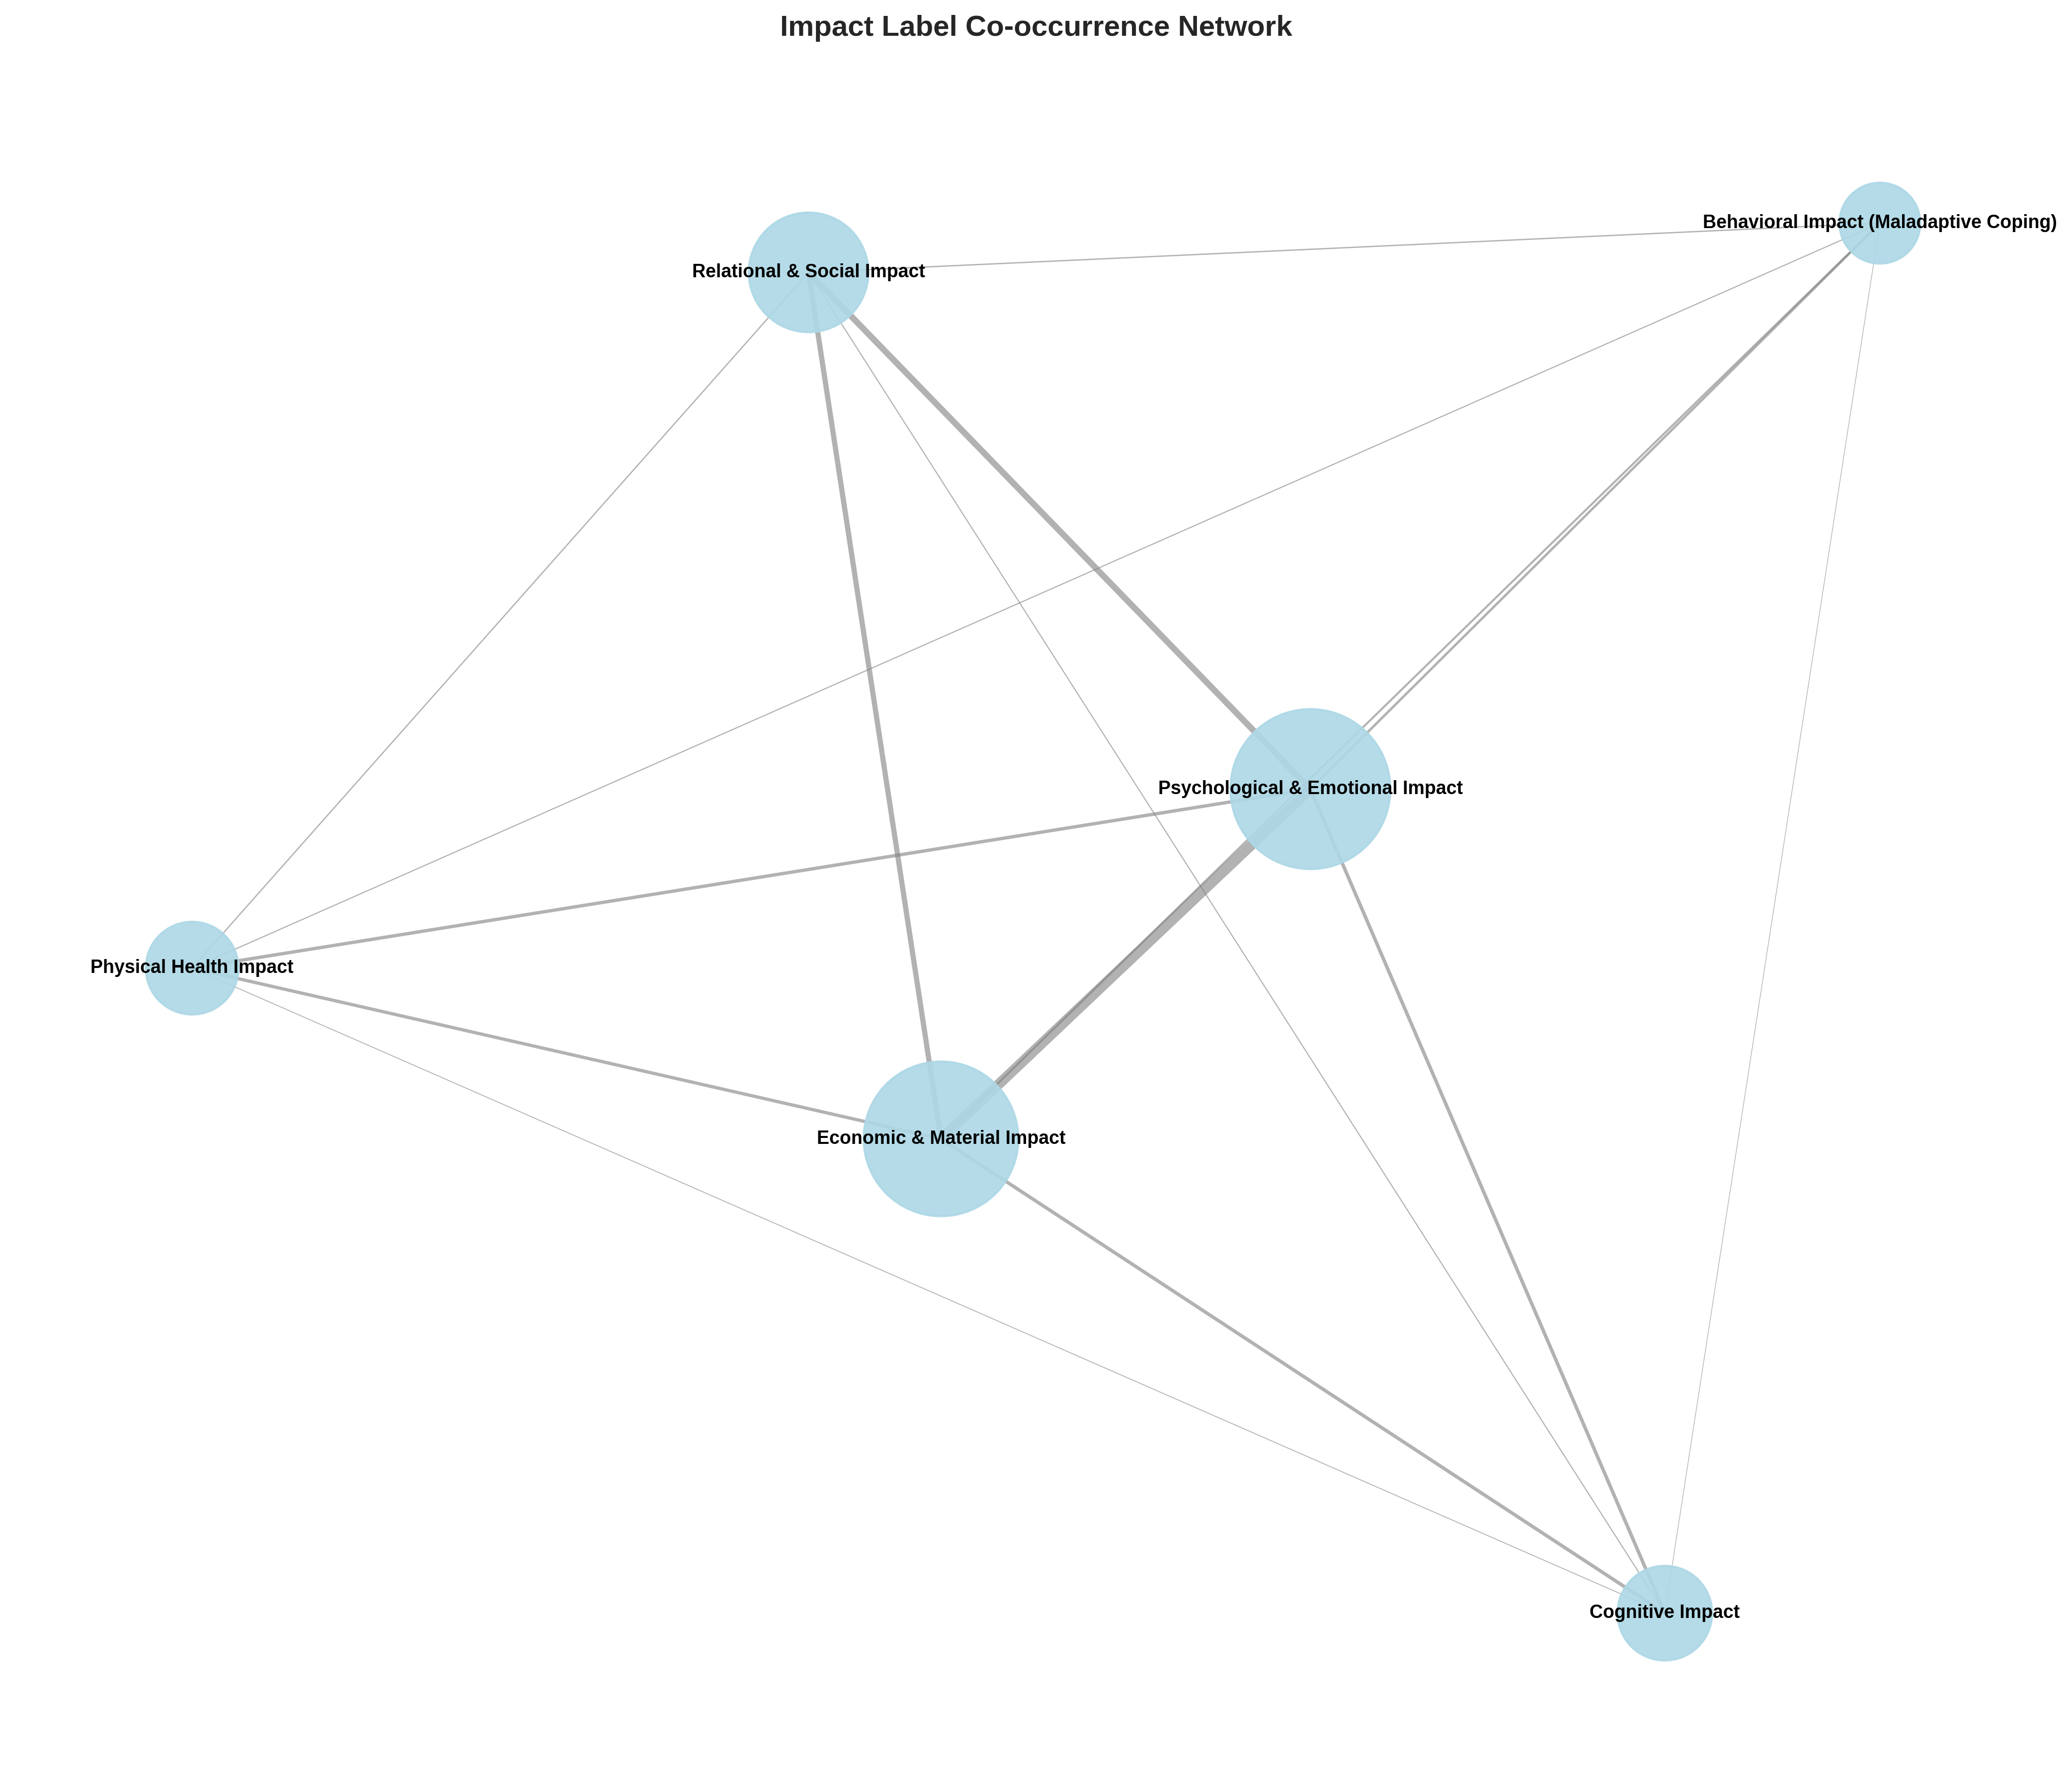

In [13]:
# ============================================================================
# APPENDIX A6: IMPACT CO-OCCURRENCE NETWORK
# ============================================================================

def create_impact_cooccurrence_network(impact_encoded, impact_labels):
    """
    Create network graph showing co-occurrence of impact labels.
    """
    # Calculate co-occurrence matrix
    cooccurrence = np.dot(impact_encoded.T, impact_encoded)

    # Create graph
    G = nx.Graph()

    # Add nodes
    for label in impact_labels:
        G.add_node(label)

    # Add edges (only if co-occurrence > threshold)
    threshold = 50  # Minimum co-occurrence to show edge

    for i in range(len(impact_labels)):
        for j in range(i + 1, len(impact_labels)):
            weight = cooccurrence[i, j]
            if weight > threshold:
                G.add_edge(impact_labels[i], impact_labels[j], weight=weight)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 12))

    # Layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

    # Draw nodes
    node_sizes = [cooccurrence[i, i] * 3 for i in range(len(impact_labels))]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                          node_color='lightblue', alpha=0.9, ax=ax)

    # Draw edges with varying thickness
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1

    nx.draw_networkx_edges(G, pos, width=[w/max_weight * 5 for w in weights],
                          alpha=0.6, edge_color='gray', ax=ax)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)

    ax.set_title('Impact Label Co-occurrence Network', fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')

    plt.tight_layout()

    return fig

# Generate figure
fig = create_impact_cooccurrence_network(impact_encoded, IMPACT_LABELS)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a6_impact_cooccurrence_network.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight', pad_inches=0.3)
print(f"Saved: {output_path}")

plt.show()